In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
tbl_dam = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tbl_dam_debito_3.csv'
tbl_historico_contribuinte = r'C:\Users\Consultor\Documents\bases_pesquisa\verificacao\tbl_historico_contribuinte_db_29_01.csv'

In [3]:
df_dam = pd.read_csv(tbl_dam, encoding='utf-8')
df_historico_contribuinte = pd.read_csv(tbl_historico_contribuinte, encoding='utf-8')

## MANIPULAÇÃO DE DADOS DA DÍVIDA

In [4]:
df_dam.head()

,id_imovel,dam,id_contribuinte,ano_fato_gerador,qtd_pavimentos,area_construida,imovel_regular,natureza_imovel,tipo_propriedade,situacao_edificacao,bairro,atualizacao_cadastro,data_ultimo_pagamento,cota_unica,idade_imovel,vlr_pago,vlr_aberto,vlr_total_dam
0,000032f6d93a0abd,2d0abb2531f5995c19002eec9f619408,71fc88ab6bbb201c344d77602867ec09,2021.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2021-01-26,1.0,38.0,2944.10,0.0,2944.10
1,000032f6d93a0abd,393f868ac32df28f4c1f696350fff79e,71fc88ab6bbb201c344d77602867ec09,2019.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2019-01-08,1.0,38.0,2627.70,0.0,2627.70
2,000032f6d93a0abd,7b9ddc3437bacdef875350beaddc7871,71fc88ab6bbb201c344d77602867ec09,2022.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2022-01-21,1.0,38.0,3335.10,0.0,3335.10
3,000032f6d93a0abd,b114a952d31c024190ecf5aaf6be6eb7,71fc88ab6bbb201c344d77602867ec09,2023.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2023-01-23,1.0,38.0,3630.40,0.0,3630.40
4,000032f6d93a0abd,d22fdd2de1578b53e08920064611a7cf,71fc88ab6bbb201c344d77602867ec09,2017.0,1,106.13,1,P,APARTAMENTO,CONSTRUÍDA,TAMARINEIRA,2008-12-11 22:19:53,2017-01-26,1.0,38.0,2459.37,0.0,2459.37


EURÍSTICA DE MANIPULAÇÃO DE DADOS ADOTADA
dam
ano_fato_gerador
id_imovel
idade_imovel 
vlr_aberto
vlr_pago
area_construida 
tipo_propriedade
bairro
NOVA COLUNA chamada vlr_lançado = vlr_aberto + vlr_pago
NOVA COLUNA chamada aberto = se vlr_lançado = vlr_pago atribuir 1, se não atribuir 0

In [5]:
colunas_selecionadas = ['dam',  'id_imovel', 'id_contribuinte', 'ano_fato_gerador', 'idade_imovel', 'area_construida',
                      'tipo_propriedade', 'bairro', 'vlr_aberto', 'vlr_pago']

feature_dam = df_dam[colunas_selecionadas].copy()

feature_dam['vlr_lancado'] = feature_dam['vlr_aberto'] + feature_dam['vlr_pago']
feature_dam['aberto'] = (feature_dam['vlr_lancado'] != feature_dam['vlr_pago']).astype(int)
feature_dam

,dam,id_imovel,id_contribuinte,ano_fato_gerador,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
0,2d0abb2531f5995c19002eec9f619408,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2021.0,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2944.10,2944.10,0
1,393f868ac32df28f4c1f696350fff79e,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2019.0,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2627.70,2627.70,0
2,7b9ddc3437bacdef875350beaddc7871,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2022.0,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3335.10,3335.10,0
3,b114a952d31c024190ecf5aaf6be6eb7,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2023.0,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3630.40,3630.40,0
4,d22fdd2de1578b53e08920064611a7cf,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2017.0,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2459.37,2459.37,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2016992,aaaca04ff960a1a5875350beaddc7871,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2022.0,41.0,89.15,APARTAMENTO,VARZEA,0.0,626.75,626.75,0
2016993,c0ff37bd120cc0d619002eec9f619408,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2021.0,41.0,89.15,APARTAMENTO,VARZEA,0.0,568.39,568.39,0
2016994,c8d60514c5f4b18ee08920064611a7cf,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2017.0,41.0,89.15,APARTAMENTO,VARZEA,0.0,503.20,503.20,0
2016995,e46ab0c52787357611babe4a46e18b6d,fffee3cacb174a68,76ab1d625a4a69d0d8b209292c0ce31d,2018.0,41.0,89.15,APARTAMENTO,VARZEA,0.0,515.10,515.10,0


In [6]:
df_dam_nulos = feature_dam[feature_dam['bairro'].isnull()]
df_dam_nulos.head()

,dam,id_imovel,id_contribuinte,ano_fato_gerador,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
153086,28e87ba0e6079ed80ba9f03948490762,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2020.0,7.0,NaN,NaN,NaN,0.00,1260.20,1260.20,0
153087,4b65dd3735737b29e08920064611a7cf,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2017.0,7.0,NaN,NaN,NaN,1713.41,0.00,1713.41,1
153088,7fd0786f77af52324c1f696350fff79e,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2019.0,7.0,NaN,NaN,NaN,0.00,1240.02,1240.02,0
153089,9803a33efc9734c9875350beaddc7871,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2022.0,7.0,NaN,NaN,NaN,0.00,1447.40,1447.40,0
153090,b183ee2216db2d3190ecf5aaf6be6eb7,137befe2d3b239ef,4ffadc1f9fe1b1b164baa3c49d28f0be,2023.0,7.0,NaN,NaN,NaN,0.00,1539.60,1539.60,0


### TRATAMENTO DOS VALORES NULOS

In [7]:
valores_nulos_por_coluna = feature_dam.isnull().sum()
valores_nulos_por_coluna

# retirar os id_contribuinte nulos ou sem documento
# area_construida preencher com 0
# idade_imovel preencher com 0         
# tipo_propriedade preencher com 'TERRENO'  
# bairro preencher com 'DESCONHECIDO'

dam                     0
id_imovel               0
id_contribuinte     82301
ano_fato_gerador        0
idade_imovel         8045
area_construida     44997
tipo_propriedade    44997
bairro                 53
vlr_aberto              0
vlr_pago                0
vlr_lancado             0
aberto                  0
dtype: int64

In [8]:
feature_dam = feature_dam.dropna(subset=['id_contribuinte']).copy()
feature_dam['area_construida'].fillna(0, inplace=True)
feature_dam['idade_imovel'].fillna(0, inplace=True)
feature_dam['tipo_propriedade'].fillna('TERRENO', inplace=True)
feature_dam['bairro'].fillna('DESCONHECIDO', inplace=True)


In [9]:
valores_nulos_por_coluna = feature_dam.isnull().sum()
valores_nulos_por_coluna

dam                 0
id_imovel           0
id_contribuinte     0
ano_fato_gerador    0
idade_imovel        0
area_construida     0
tipo_propriedade    0
bairro              0
vlr_aberto          0
vlr_pago            0
vlr_lancado         0
aberto              0
dtype: int64

In [10]:
feature_dam.head()

,dam,id_imovel,id_contribuinte,ano_fato_gerador,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
0,2d0abb2531f5995c19002eec9f619408,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2021.0,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2944.10,2944.10,0
1,393f868ac32df28f4c1f696350fff79e,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2019.0,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2627.70,2627.70,0
2,7b9ddc3437bacdef875350beaddc7871,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2022.0,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3335.10,3335.10,0
3,b114a952d31c024190ecf5aaf6be6eb7,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2023.0,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3630.40,3630.40,0
4,d22fdd2de1578b53e08920064611a7cf,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,2017.0,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,2459.37,2459.37,0


## MANIPULAÇÃO DE DADOS DO CONTRIBUINTE

In [479]:
df_historico_contribuinte.head()

,ano,id_contribuinte,reco_debito,reco_divida_ativa,freq_parcelamento,hist_pagamento_qtd,num_imoveis,pgt_cota_unica,hist_aberto_qtd,hist_dams_totais,hist_valor_aberto,hist_valor_pago,hist_valor_total
0,2013,00001a3e5b2177499daa7b7dbb545c1c,0,0,0,0,0,0,0,0,0.0,0.0,0.0
1,2013,0000398c485f8b42344d77602867ec09,0,0,0,0,0,0,0,0,0.0,0.0,0.0
2,2013,00003a695da4777aec557718ffae83ea,0,0,0,0,0,0,0,0,0.0,0.0,0.0
3,2013,000046c85d18a6f7968646cfc1e328f2,0,0,0,0,0,0,0,0,0.0,0.0,0.0
4,2013,0000b23be5378f1b8e79cf1867e8cc19,0,0,0,0,0,0,0,0,0.0,0.0,0.0


EURÍSTICA ADOTADA PARA MANIPULAÇÃO DE DADOS

id_contribuinte
pgt_cota_unica
hist_pagamento
hist_valor_lançado
num_imoveis
reco_divida 
existe esta coluna reco_debito, eu calculei para esta coluna o valor contido em reco_debito + o valor contido em reco_divida sendo o total preenchido na coluna reco_debito
NOVA COLUNA reco_credito = a logica dessa coluna será a seguinte: será contar quantos id_contribuinte tem quando hist_valor_total for diferente de 0 em relação aos anos anteriores. exemplo: eu tenho na minha base o registo xxxx e eu tenho na base os anos entre 2013 e 2023 certo? quando for o registro de 2017 desse contribuinte xxxx eu vou realizar a logica olhando quantas vezes esse id_contribuinte apareceu até este ano em que o hist_valor_total foi diferente de 0 considerando tambem o ano atual, neste exemplo 2017 no caso, e assim cada ano eu terei a quantidade atualizada.

In [480]:
feature_contribuinte = df_historico_contribuinte[['ano', 'id_contribuinte', 'pgt_cota_unica', 'hist_valor_pago', 'hist_valor_total', 'num_imoveis', 'reco_divida_ativa']].copy()
feature_contribuinte['hist_cota_unica'] = feature_contribuinte.groupby('id_contribuinte')['pgt_cota_unica'].cumsum()

# Desconsidero o ano de vigência e faço o acumulado eem relação aos anos anteriores
feature_contribuinte['hist_pagamento'] = feature_contribuinte.groupby('id_contribuinte')['hist_valor_pago'].cumsum()
feature_contribuinte['hist_lancado'] = feature_contribuinte.groupby('id_contribuinte')['hist_valor_total'].cumsum()

# reco_debito
feature_contribuinte['reco_debito'] = df_historico_contribuinte['reco_debito'] + df_historico_contribuinte['reco_divida_ativa']
feature_contribuinte['reco_credito'] = df_historico_contribuinte.groupby('id_contribuinte')['hist_valor_total'].apply(lambda x: (x.shift(1) != 0).cumsum())
feature_contribuinte['reco_credito'] = np.where(df_historico_contribuinte['hist_valor_total'] == 0, 0, feature_contribuinte['reco_credito'])

feature_contribuinte

,ano,id_contribuinte,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito
0,2013,00001a3e5b2177499daa7b7dbb545c1c,0,0.00,0.00,0,0,0,0.00,0.00,0,0
1,2013,0000398c485f8b42344d77602867ec09,0,0.00,0.00,0,0,0,0.00,0.00,0,0
2,2013,00003a695da4777aec557718ffae83ea,0,0.00,0.00,0,0,0,0.00,0.00,0,0
3,2013,000046c85d18a6f7968646cfc1e328f2,0,0.00,0.00,0,0,0,0.00,0.00,0,0
4,2013,0000b23be5378f1b8e79cf1867e8cc19,0,0.00,0.00,0,0,0,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2763965,2023,ffff0e3e56845cdf1603ecd7ff6be21f,0,645.20,645.20,1,0,0,3202.69,3789.56,0,7
2763966,2023,ffff3836dbf935321bc34267b5521a39,0,5913.49,5913.49,1,0,0,37074.07,37074.07,0,8
2763967,2023,ffff63826b501d84d8b209292c0ce31d,0,2085.70,2085.70,1,0,0,13677.51,13677.51,0,8
2763968,2023,ffffc6563e67d8b38e79cf1867e8cc19,1,2532.70,2532.70,2,0,1,14683.46,14683.46,0,7


In [482]:
feature_contribuinte = feature_contribuinte.drop(columns=['hist_valor_pago'])
feature_contribuinte = feature_contribuinte.drop(columns=['hist_valor_total'])

In [481]:
feature_contribuinte.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,ano,id_contribuinte,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito
44513,2013,2d6ae6e5dd1e57efae08d57f53945088,0,0.00,0.00,0,1,0,0.00,0.00,1,0
295783,2014,2d6ae6e5dd1e57efae08d57f53945088,0,0.00,0.00,0,1,0,0.00,0.00,1,0
547053,2015,2d6ae6e5dd1e57efae08d57f53945088,0,0.00,1482.67,1,0,0,0.00,1482.67,0,1
798323,2016,2d6ae6e5dd1e57efae08d57f53945088,0,0.00,0.00,0,1,0,0.00,1482.67,1,0
1049593,2017,2d6ae6e5dd1e57efae08d57f53945088,0,0.00,0.00,0,0,0,0.00,1482.67,0,0
1300863,2018,2d6ae6e5dd1e57efae08d57f53945088,1,1818.18,1818.18,1,0,1,1818.18,3300.85,0,2
1552133,2019,2d6ae6e5dd1e57efae08d57f53945088,1,1814.94,1814.94,1,0,2,3633.12,5115.79,0,3
1803403,2020,2d6ae6e5dd1e57efae08d57f53945088,1,1811.40,1811.40,1,0,3,5444.52,6927.19,0,4
2054673,2021,2d6ae6e5dd1e57efae08d57f53945088,1,1807.74,1807.74,1,0,4,7252.26,8734.93,0,5
2305943,2022,2d6ae6e5dd1e57efae08d57f53945088,1,1803.81,1803.81,1,0,5,9056.07,10538.74,0,6


In [483]:
valores_nulos_por_coluna = feature_contribuinte.isnull().sum()
valores_nulos_por_coluna

ano                  0
id_contribuinte      0
pgt_cota_unica       0
num_imoveis          0
reco_divida_ativa    0
hist_cota_unica      0
hist_pagamento       0
hist_lancado         0
reco_debito          0
reco_credito         0
dtype: int64

In [484]:
feature_contribuinte = feature_contribuinte.query('ano >= 2017')
feature_contribuinte

,ano,id_contribuinte,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito
1005080,2017,00001a3e5b2177499daa7b7dbb545c1c,0,0,0,0,0.00,0.00,0,0
1005081,2017,0000398c485f8b42344d77602867ec09,0,1,0,0,721.31,721.31,0,1
1005082,2017,00003a695da4777aec557718ffae83ea,0,1,0,0,2668.51,2668.51,0,2
1005083,2017,000046c85d18a6f7968646cfc1e328f2,0,1,0,0,5542.50,5542.50,0,2
1005084,2017,0000b23be5378f1b8e79cf1867e8cc19,0,4,0,0,3624.20,3624.20,0,2
...,...,...,...,...,...,...,...,...,...,...
2763965,2023,ffff0e3e56845cdf1603ecd7ff6be21f,0,1,0,0,3202.69,3789.56,0,7
2763966,2023,ffff3836dbf935321bc34267b5521a39,0,1,0,0,37074.07,37074.07,0,8
2763967,2023,ffff63826b501d84d8b209292c0ce31d,0,1,0,0,13677.51,13677.51,0,8
2763968,2023,ffffc6563e67d8b38e79cf1867e8cc19,1,2,0,1,14683.46,14683.46,0,7


In [485]:
valores_nulos_por_coluna = feature_contribuinte.isnull().sum()
valores_nulos_por_coluna

ano                  0
id_contribuinte      0
pgt_cota_unica       0
num_imoveis          0
reco_divida_ativa    0
hist_cota_unica      0
hist_pagamento       0
hist_lancado         0
reco_debito          0
reco_credito         0
dtype: int64

In [486]:
valores_nulos_por_coluna = feature_dam.isnull().sum()
valores_nulos_por_coluna

dam                 0
id_imovel           0
id_contribuinte     0
ano_fato_gerador    0
idade_imovel        0
area_construida     0
tipo_propriedade    0
bairro              0
vlr_aberto          0
vlr_pago            0
vlr_lancado         0
aberto              0
dtype: int64

### Unindo e agrupando a título de análise

In [ ]:
# Agrupando por id_contribuinte
ft_contribu = feature_contribuinte.groupby(['id_contribuinte']).agg({
    'hist_valor_pago': 'sum',
    'pgt_cota_unica': 'sum',
    'hist_valor_total': 'sum',
    'num_imoveis': 'sum',
    'reco_credito': 'sum',
    'reco_debito': 'sum',
    'reco_divida_ativa': 'sum'
}).reset_index()
ft_contribu

In [ ]:
ft_contribu['percentual_pago'] = (ft_contribu['hist_valor_pago'] / ft_contribu['hist_valor_total'] * 100).fillna(0)
ft_contribu

---

# UNIFICANDO O FEATURE STORE

### EURÍSTICA ADOTADA

* Cada Dam reflete um ano em específico
* Os dados do contribuinte estão na mesma granularidade que a DAM

In [711]:
feature_dam.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,dam,id_imovel,id_contribuinte,ano_fato_gerador,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto
1461637,0242d546cc1bdeaa90ecf5aaf6be6eb7,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2023.0,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1799.62,1799.62,0
1461638,5a442ba816b8eb3919002eec9f619408,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2021.0,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1807.74,1807.74,0
1461639,93330731628f4fea875350beaddc7871,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2022.0,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1803.81,1803.81,0
1461640,a51035cc3c80acf14c1f696350fff79e,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2019.0,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1814.94,1814.94,0
1461641,bfb0b6cb96105ef40ba9f03948490762,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2020.0,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1811.40,1811.40,0
1461642,d1460d862a9c557811babe4a46e18b6d,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2018.0,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1818.18,1818.18,0


In [599]:
feature_contribuinte.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,ano,id_contribuinte,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito
1049593,2017,2d6ae6e5dd1e57efae08d57f53945088,0,0,0,0,0.00,1482.67,0,0
1300863,2018,2d6ae6e5dd1e57efae08d57f53945088,1,1,0,1,1818.18,3300.85,0,2
1552133,2019,2d6ae6e5dd1e57efae08d57f53945088,1,1,0,2,3633.12,5115.79,0,3
1803403,2020,2d6ae6e5dd1e57efae08d57f53945088,1,1,0,3,5444.52,6927.19,0,4
2054673,2021,2d6ae6e5dd1e57efae08d57f53945088,1,1,0,4,7252.26,8734.93,0,5
2305943,2022,2d6ae6e5dd1e57efae08d57f53945088,1,1,0,5,9056.07,10538.74,0,6
2557213,2023,2d6ae6e5dd1e57efae08d57f53945088,1,1,0,6,10855.69,12338.36,0,7


In [600]:
feature_store_credito = pd.merge(feature_dam, feature_contribuinte, 
                  left_on=['id_contribuinte', 'ano_fato_gerador'], 
                  right_on=['id_contribuinte', 'ano'], 
                  how='left')
feature_store_credito
feature_store_credito = feature_store_credito.sort_values(by=['id_contribuinte', 'ano'])
feature_store_credito

,dam,id_imovel,id_contribuinte,ano_fato_gerador,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,...,aberto,ano,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito
193475,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2017.0,55.0,110.15,CASA,AREIAS,0.00,721.31,...,0,2017.0,0.0,1.0,0.0,0.0,721.31,721.31,0.0,1.0
193476,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2022.0,55.0,110.15,CASA,AREIAS,1306.50,0.00,...,1,2022.0,0.0,1.0,1.0,0.0,721.31,2100.81,2.0,2.0
193474,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,2023.0,55.0,110.15,CASA,AREIAS,1158.44,0.00,...,1,2023.0,0.0,1.0,0.0,0.0,721.31,3339.77,1.0,3.0
814792,5aa15e7ff42aedb9e08920064611a7cf,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,2017.0,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1453.81,...,0,2017.0,0.0,1.0,0.0,0.0,2668.51,2668.51,0.0,2.0
814793,6d4837a02187b5d211babe4a46e18b6d,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,2018.0,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1486.60,...,0,2018.0,0.0,1.0,0.0,0.0,4155.11,4155.11,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265931,ef11c710269f05504c1f696350fff79e,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2019.0,15.0,93.60,CASA,COHAB,0.00,595.70,...,0,2019.0,0.0,1.0,0.0,0.0,4678.52,4678.52,0.0,5.0
265929,a5dbee1cfd0fe49c0ba9f03948490762,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2020.0,15.0,93.60,CASA,COHAB,0.00,621.13,...,0,2020.0,0.0,1.0,0.0,0.0,5310.62,5310.62,0.0,6.0
265927,7ace6937886e01b219002eec9f619408,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2021.0,15.0,93.60,CASA,COHAB,0.00,633.40,...,0,2021.0,0.0,1.0,0.0,0.0,5944.02,5944.02,0.0,7.0
265925,0b85676f02241e7a875350beaddc7871,233f75a5f20edef9,ffffe7d2325d80e6d8b209292c0ce31d,2022.0,15.0,93.60,CASA,COHAB,0.00,702.28,...,0,2022.0,0.0,1.0,0.0,0.0,6648.40,6648.40,0.0,8.0


In [601]:
feature_store_credito.query('id_contribuinte == "2d6ae6e5dd1e57efae08d57f53945088"')

,dam,id_imovel,id_contribuinte,ano_fato_gerador,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,...,aberto,ano,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito
1402065,d1460d862a9c557811babe4a46e18b6d,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2018.0,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1818.18,...,0,2018.0,1.0,1.0,0.0,1.0,1818.18,3300.85,0.0,2.0
1402063,a51035cc3c80acf14c1f696350fff79e,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2019.0,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1814.94,...,0,2019.0,1.0,1.0,0.0,2.0,3633.12,5115.79,0.0,3.0
1402064,bfb0b6cb96105ef40ba9f03948490762,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2020.0,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1811.40,...,0,2020.0,1.0,1.0,0.0,3.0,5444.52,6927.19,0.0,4.0
1402061,5a442ba816b8eb3919002eec9f619408,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2021.0,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1807.74,...,0,2021.0,1.0,1.0,0.0,4.0,7252.26,8734.93,0.0,5.0
1402062,93330731628f4fea875350beaddc7871,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2022.0,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1803.81,...,0,2022.0,1.0,1.0,0.0,5.0,9056.07,10538.74,0.0,6.0
1402060,0242d546cc1bdeaa90ecf5aaf6be6eb7,b99a4cd3eca45812,2d6ae6e5dd1e57efae08d57f53945088,2023.0,17.0,100.86,APARTAMENTO,BOA VIAGEM,0.0,1799.62,...,0,2023.0,1.0,1.0,0.0,6.0,10855.69,12338.36,0.0,7.0


In [602]:
valores_nulos_por_coluna = feature_store_credito.isnull().sum()
valores_nulos_por_coluna

dam                    0
id_imovel              0
id_contribuinte        0
ano_fato_gerador       0
idade_imovel           0
area_construida        0
tipo_propriedade       0
bairro                 0
vlr_aberto             0
vlr_pago               0
vlr_lancado            0
aberto                 0
ano                  479
pgt_cota_unica       479
num_imoveis          479
reco_divida_ativa    479
hist_cota_unica      479
hist_pagamento       479
hist_lancado         479
reco_debito          479
reco_credito         479
dtype: int64

In [603]:
feature_store_credito.query('ano.isnull()')

,dam,id_imovel,id_contribuinte,ano_fato_gerador,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,...,aberto,ano,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito
1048925,4998c070f45f744719002eec9f619408,8aa6c5cbcd341cef,0dd9f9468067d90add9a3cb674b9fb28,2021.0,11.0,98.50,APARTAMENTO,BOA VIAGEM,0.0,1553.90,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048926,7bb68000fec6fbc1875350beaddc7871,8aa6c5cbcd341cef,0dd9f9468067d90add9a3cb674b9fb28,2022.0,11.0,98.50,APARTAMENTO,BOA VIAGEM,0.0,1931.30,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048927,9b90b018774d23274c1f696350fff79e,8aa6c5cbcd341cef,0dd9f9468067d90add9a3cb674b9fb28,2019.0,11.0,98.50,APARTAMENTO,BOA VIAGEM,0.0,1329.40,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048928,9ce9d52dcac11e23e08920064611a7cf,8aa6c5cbcd341cef,0dd9f9468067d90add9a3cb674b9fb28,2017.0,11.0,98.50,APARTAMENTO,BOA VIAGEM,0.0,1390.30,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048929,b8f8e420c219a4490ba9f03948490762,8aa6c5cbcd341cef,0dd9f9468067d90add9a3cb674b9fb28,2020.0,11.0,98.50,APARTAMENTO,BOA VIAGEM,0.0,1586.06,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709082,b1c386c9270e1cd8e08920064611a7cf,5d8bdc64a1cf32c5,ff8d41fe201c3d29967864cf94c3bc47,2017.0,12.0,92.13,APARTAMENTO,AGUA FRIA,0.0,1175.41,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
709083,b663797df5c010bb11babe4a46e18b6d,5d8bdc64a1cf32c5,ff8d41fe201c3d29967864cf94c3bc47,2018.0,12.0,92.13,APARTAMENTO,AGUA FRIA,0.0,1119.40,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56361,20242c321ec91b5d875350beaddc7871,077458632e339882,ff97c777edf549cffafaebd1073fc2f4,2022.0,15.0,151.45,APARTAMENTO,BOA VIAGEM,0.0,3876.03,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56362,79b65228c98a902019002eec9f619408,077458632e339882,ff97c777edf549cffafaebd1073fc2f4,2021.0,15.0,151.45,APARTAMENTO,BOA VIAGEM,0.0,3419.90,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [604]:
feature_store_credito = feature_store_credito.dropna(subset=['ano'])

In [605]:
valores_nulos_por_coluna = feature_store_credito.isnull().sum()
valores_nulos_por_coluna

dam                  0
id_imovel            0
id_contribuinte      0
ano_fato_gerador     0
idade_imovel         0
area_construida      0
tipo_propriedade     0
bairro               0
vlr_aberto           0
vlr_pago             0
vlr_lancado          0
aberto               0
ano                  0
pgt_cota_unica       0
num_imoveis          0
reco_divida_ativa    0
hist_cota_unica      0
hist_pagamento       0
hist_lancado         0
reco_debito          0
reco_credito         0
dtype: int64

In [606]:
feature_store_credito = feature_store_credito.drop(columns=['ano_fato_gerador'])

In [607]:
feature_store_credito.head(10)

,dam,id_imovel,id_contribuinte,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,aberto,ano,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito
193475,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,55.0,110.15,CASA,AREIAS,0.00,721.31,721.31,0,2017.0,0.0,1.0,0.0,0.0,721.31,721.31,0.0,1.0
193476,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,55.0,110.15,CASA,AREIAS,1306.50,0.00,1306.50,1,2022.0,0.0,1.0,1.0,0.0,721.31,2100.81,2.0,2.0
193474,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,55.0,110.15,CASA,AREIAS,1158.44,0.00,1158.44,1,2023.0,0.0,1.0,0.0,0.0,721.31,3339.77,1.0,3.0
814792,5aa15e7ff42aedb9e08920064611a7cf,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1453.81,1453.81,0,2017.0,0.0,1.0,0.0,0.0,2668.51,2668.51,0.0,2.0
814793,6d4837a02187b5d211babe4a46e18b6d,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1486.60,1486.60,0,2018.0,0.0,1.0,0.0,0.0,4155.11,4155.11,0.0,3.0
814791,277b2982d51e63514c1f696350fff79e,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1547.20,1547.20,0,2019.0,0.0,1.0,0.0,0.0,5702.31,5702.31,0.0,4.0
814789,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1579.00,1579.00,0,2020.0,0.0,1.0,0.0,0.0,7281.31,7281.31,0.0,5.0
814795,e62adcde1ec2469e19002eec9f619408,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1633.00,1633.00,0,2021.0,0.0,1.0,0.0,0.0,8914.31,8914.31,0.0,6.0
814790,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1798.10,1798.10,0,2022.0,0.0,1.0,0.0,0.0,10712.41,10712.41,0.0,7.0
814794,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1904.40,1904.40,0,2023.0,0.0,1.0,0.0,0.0,12616.81,12616.81,0.0,8.0


### ADICIONANDO VARIÁVEL RESPOSTA

In [608]:
feature_store_credito['percentual_pago'] = (feature_store_credito['vlr_pago'] / feature_store_credito['vlr_lancado']).fillna(0)

In [609]:
feature_store_credito.head(10)

,dam,id_imovel,id_contribuinte,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,...,ano,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,percentual_pago
193475,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,55.0,110.15,CASA,AREIAS,0.00,721.31,721.31,...,2017.0,0.0,1.0,0.0,0.0,721.31,721.31,0.0,1.0,1.0
193476,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,55.0,110.15,CASA,AREIAS,1306.50,0.00,1306.50,...,2022.0,0.0,1.0,1.0,0.0,721.31,2100.81,2.0,2.0,0.0
193474,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,55.0,110.15,CASA,AREIAS,1158.44,0.00,1158.44,...,2023.0,0.0,1.0,0.0,0.0,721.31,3339.77,1.0,3.0,0.0
814792,5aa15e7ff42aedb9e08920064611a7cf,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1453.81,1453.81,...,2017.0,0.0,1.0,0.0,0.0,2668.51,2668.51,0.0,2.0,1.0
814793,6d4837a02187b5d211babe4a46e18b6d,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1486.60,1486.60,...,2018.0,0.0,1.0,0.0,0.0,4155.11,4155.11,0.0,3.0,1.0
814791,277b2982d51e63514c1f696350fff79e,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1547.20,1547.20,...,2019.0,0.0,1.0,0.0,0.0,5702.31,5702.31,0.0,4.0,1.0
814789,0ef80ae81185fad10ba9f03948490762,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1579.00,1579.00,...,2020.0,0.0,1.0,0.0,0.0,7281.31,7281.31,0.0,5.0,1.0
814795,e62adcde1ec2469e19002eec9f619408,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1633.00,1633.00,...,2021.0,0.0,1.0,0.0,0.0,8914.31,8914.31,0.0,6.0,1.0
814790,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1798.10,1798.10,...,2022.0,0.0,1.0,0.0,0.0,10712.41,10712.41,0.0,7.0,1.0
814794,9b2d05920c173e8190ecf5aaf6be6eb7,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1904.40,1904.40,...,2023.0,0.0,1.0,0.0,0.0,12616.81,12616.81,0.0,8.0,1.0


In [610]:
feature_store_credito.columns

Index(['dam', 'id_imovel', 'id_contribuinte', 'idade_imovel',
       'area_construida', 'tipo_propriedade', 'bairro', 'vlr_aberto',
       'vlr_pago', 'vlr_lancado', 'aberto', 'ano', 'pgt_cota_unica',
       'num_imoveis', 'reco_divida_ativa', 'hist_cota_unica', 'hist_pagamento',
       'hist_lancado', 'reco_debito', 'reco_credito', 'percentual_pago'],
      dtype='object')

consolidar

In [611]:
feature_store_credito.query('dam == "19829fbe189bd95be08920064611a7cf"')

,dam,id_imovel,id_contribuinte,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,...,ano,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,percentual_pago
1551334,19829fbe189bd95be08920064611a7cf,cd8021faac24a9d5,b610c9e633c60c2e0246e2b93c1bf25c,22.0,76.58,APARTAMENTO,ARRUDA,0.00,24.84,24.84,...,2017.0,0.0,1.0,0.0,0.0,693.76,1588.84,0.0,4.0,1.0
1551335,19829fbe189bd95be08920064611a7cf,cd8021faac24a9d5,b610c9e633c60c2e0246e2b93c1bf25c,22.0,76.58,APARTAMENTO,ARRUDA,689.91,0.00,689.91,...,2017.0,0.0,1.0,0.0,0.0,693.76,1588.84,0.0,4.0,0.0
1551336,19829fbe189bd95be08920064611a7cf,cd8021faac24a9d5,b610c9e633c60c2e0246e2b93c1bf25c,22.0,76.58,APARTAMENTO,ARRUDA,0.00,59.84,59.84,...,2017.0,0.0,1.0,0.0,0.0,693.76,1588.84,0.0,4.0,1.0


In [612]:
feature_store_credito.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1934217 entries, 193475 to 265926
Data columns (total 21 columns):
 #   Column             Dtype  
---  ------             -----  
 0   dam                object 
 1   id_imovel          object 
 2   id_contribuinte    object 
 3   idade_imovel       float64
 4   area_construida    float64
 5   tipo_propriedade   object 
 6   bairro             object 
 7   vlr_aberto         float64
 8   vlr_pago           float64
 9   vlr_lancado        float64
 10  aberto             int32  
 11  ano                float64
 12  pgt_cota_unica     float64
 13  num_imoveis        float64
 14  reco_divida_ativa  float64
 15  hist_cota_unica    float64
 16  hist_pagamento     float64
 17  hist_lancado       float64
 18  reco_debito        float64
 19  reco_credito       float64
 20  percentual_pago    float64
dtypes: float64(15), int32(1), object(5)
memory usage: 317.3+ MB


In [613]:
feature_store_credito.select_dtypes(include='object').describe()

,dam,id_imovel,id_contribuinte,tipo_propriedade,bairro
count,1934217,1934217,1934217,1934217,1934217
unique,1924718,348249,219454,20,95
top,19829fbe189bd95be08920064611a7cf,1e1e2fb1d7c6cb5f,15b31504d4b77fb69788d012a601b87f,APARTAMENTO,BOA VIAGEM
freq,3,19,6875,1151530,411753


### ONEHOTENCODER

In [90]:
df_feature_categ = feature_store_credito.select_dtypes(include='object')

In [89]:
from category_encoders.one_hot import OneHotEncoder
one_hot_enc = OneHotEncoder(cols=['tipo_propriedade'])

In [ ]:
one_hot_enc.fit_transform(df_feature_categ)

---

## VISUALIZAÇÃO DA VARIÁVEL TARGET

In [614]:
feature_store_credito.columns

Index(['dam', 'id_imovel', 'id_contribuinte', 'idade_imovel',
       'area_construida', 'tipo_propriedade', 'bairro', 'vlr_aberto',
       'vlr_pago', 'vlr_lancado', 'aberto', 'ano', 'pgt_cota_unica',
       'num_imoveis', 'reco_divida_ativa', 'hist_cota_unica', 'hist_pagamento',
       'hist_lancado', 'reco_debito', 'reco_credito', 'percentual_pago'],
      dtype='object')

In [615]:
feature_store_credito.head()

,dam,id_imovel,id_contribuinte,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,...,ano,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,percentual_pago
193475,864f3b605305965ae08920064611a7cf,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,55.0,110.15,CASA,AREIAS,0.00,721.31,721.31,...,2017.0,0.0,1.0,0.0,0.0,721.31,721.31,0.0,1.0,1.0
193476,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,55.0,110.15,CASA,AREIAS,1306.50,0.00,1306.50,...,2022.0,0.0,1.0,1.0,0.0,721.31,2100.81,2.0,2.0,0.0
193474,13fbc8d9654c9e3190ecf5aaf6be6eb7,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,55.0,110.15,CASA,AREIAS,1158.44,0.00,1158.44,...,2023.0,0.0,1.0,0.0,0.0,721.31,3339.77,1.0,3.0,0.0
814792,5aa15e7ff42aedb9e08920064611a7cf,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1453.81,1453.81,...,2017.0,0.0,1.0,0.0,0.0,2668.51,2668.51,0.0,2.0,1.0
814793,6d4837a02187b5d211babe4a46e18b6d,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.00,1486.60,1486.60,...,2018.0,0.0,1.0,0.0,0.0,4155.11,4155.11,0.0,3.0,1.0


In [616]:
feature_store_credito_sem_outliers = feature_store_credito.copy()

In [617]:
# TRATAMENTO DE OUTLIERS
from scipy.stats.mstats import winsorize
feature_store_credito_sem_outliers['idade_imovel'] = winsorize(feature_store_credito_sem_outliers['idade_imovel'], limits=[0.05, 0.05])
feature_store_credito_sem_outliers['area_construida'] = winsorize(feature_store_credito_sem_outliers['area_construida'], limits=[0.05, 0.05])
feature_store_credito_sem_outliers['vlr_pago'] = winsorize(feature_store_credito_sem_outliers['vlr_pago'], limits=[0.05, 0.05])
feature_store_credito_sem_outliers['pgt_cota_unica'] = winsorize(feature_store_credito_sem_outliers['pgt_cota_unica'], limits=[0.05, 0.05])
feature_store_credito_sem_outliers['vlr_lancado'] = winsorize(feature_store_credito_sem_outliers['vlr_lancado'], limits=[0.05, 0.05])
feature_store_credito_sem_outliers['vlr_aberto'] = winsorize(feature_store_credito_sem_outliers['vlr_aberto'], limits=[0.05, 0.05])
feature_store_credito_sem_outliers['hist_pagamento'] = winsorize(feature_store_credito_sem_outliers['hist_pagamento'], limits=[0.05, 0.05])
feature_store_credito_sem_outliers['hist_lancado'] = winsorize(feature_store_credito_sem_outliers['hist_lancado'], limits=[0.05, 0.05])
feature_store_credito_sem_outliers['num_imoveis'] = winsorize(feature_store_credito_sem_outliers['num_imoveis'], limits=[0.05, 0.05])
feature_store_credito_sem_outliers['reco_divida_ativa'] = winsorize(feature_store_credito_sem_outliers['reco_divida_ativa'], limits=[0.05, 0.05])
feature_store_credito_sem_outliers['reco_debito'] = winsorize(feature_store_credito_sem_outliers['reco_debito'], limits=[0.05, 0.05])
feature_store_credito_sem_outliers['percentual_pago'] = winsorize(feature_store_credito_sem_outliers['percentual_pago'], limits=[0.05, 0.05])

### Parece não ter uma correlação Linear - Dados sem tratamento de outliers

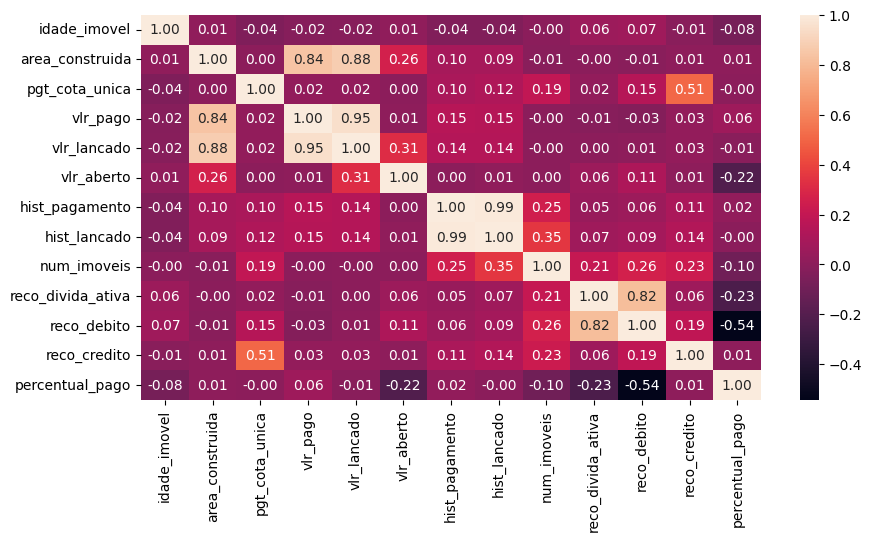

In [618]:
matriz_correlacao = feature_store_credito[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 
                                    'hist_lancado', 'num_imoveis', 
                                    'reco_divida_ativa','reco_debito','reco_credito','percentual_pago']].corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

### Parece não ter uma correlação Linear - Dados com tratamento de outliers

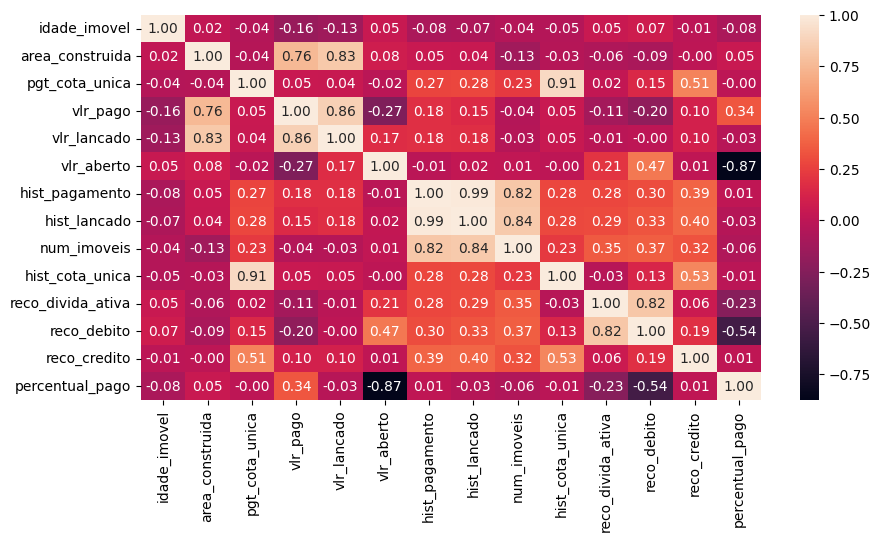

In [619]:
matriz_correlacao = feature_store_credito_sem_outliers[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 
                                    'hist_lancado', 'num_imoveis', 'hist_cota_unica',
                                    'reco_divida_ativa','reco_debito','reco_credito','percentual_pago']].corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

In [620]:
from scipy.stats import spearmanr

matriz_correlacao_rank = feature_store_credito[['idade_imovel', 'area_construida',  'pgt_cota_unica',
                                    'vlr_pago', 'vlr_lancado', 'vlr_aberto', 'hist_pagamento', 
                                    'hist_lancado', 'num_imoveis', 'hist_cota_unica',
                                    'reco_divida_ativa','reco_debito','reco_credito','percentual_pago']].corr(method='spearman')



In [621]:
matriz_correlacao_rank

,idade_imovel,area_construida,pgt_cota_unica,vlr_pago,vlr_lancado,vlr_aberto,hist_pagamento,hist_lancado,num_imoveis,hist_cota_unica,reco_divida_ativa,reco_debito,reco_credito,percentual_pago
idade_imovel,1.000000,-0.022736,-0.048389,-0.245848,-0.239222,0.072503,-0.179428,-0.168285,-0.080293,-0.053090,0.053969,0.073358,-0.009833,-0.078785
area_construida,-0.022736,1.000000,-0.052295,0.672334,0.804584,-0.034378,0.231925,0.243040,-0.142175,-0.052756,-0.099509,-0.130770,-0.013615,0.063926
pgt_cota_unica,-0.048389,-0.052295,1.000000,0.044906,0.039509,-0.004206,0.302533,0.291002,0.238954,0.956026,0.018685,0.114200,0.491804,0.000783
vlr_pago,-0.245848,0.672334,0.044906,1.000000,0.770272,-0.507463,0.475059,0.396821,0.032747,0.044286,-0.182205,-0.321479,0.112362,0.522800
vlr_lancado,-0.239222,0.804584,0.039509,0.770272,1.000000,0.063309,0.434397,0.472037,0.025973,0.045094,-0.049293,-0.038151,0.112626,-0.027757
vlr_aberto,0.072503,-0.034378,-0.004206,-0.507463,0.063309,1.000000,-0.161272,-0.005527,-0.008696,0.009646,0.220405,0.527780,0.003659,-0.994783
hist_pagamento,-0.179428,0.231925,0.302533,0.475059,0.434397,-0.161272,1.000000,0.961115,0.740688,0.306279,0.150720,0.127371,0.573654,0.172858
hist_lancado,-0.168285,0.243040,0.291002,0.396821,0.472037,-0.005527,0.961115,1.000000,0.762267,0.294813,0.201192,0.230014,0.566001,0.019774
num_imoveis,-0.080293,-0.142175,0.238954,0.032747,0.025973,-0.008696,0.740688,0.762267,1.000000,0.234946,0.314808,0.325861,0.341848,0.005980
hist_cota_unica,-0.053090,-0.052756,0.956026,0.044286,0.045094,0.009646,0.306279,0.294813,0.234946,1.000000,-0.005424,0.117816,0.516002,-0.012647


---

# INICIANDO CONSTRUÇÃO DO MODELO

In [622]:
feature_store_credito.columns

Index(['dam', 'id_imovel', 'id_contribuinte', 'idade_imovel',
       'area_construida', 'tipo_propriedade', 'bairro', 'vlr_aberto',
       'vlr_pago', 'vlr_lancado', 'aberto', 'ano', 'pgt_cota_unica',
       'num_imoveis', 'reco_divida_ativa', 'hist_cota_unica', 'hist_pagamento',
       'hist_lancado', 'reco_debito', 'reco_credito', 'percentual_pago'],
      dtype='object')

## Filtrando dados até 2022 para treino e teste

In [623]:
feature_store_credito_ate_22 = feature_store_credito.query('ano < 2023')
feature_store_credito_22 = feature_store_credito.query('ano == 2022')
feature_store_credito_23 = feature_store_credito.query('ano == 2023')
feature_store_credito_22_23 = feature_store_credito.query('ano > 2021')

### No ano de 2022 30% dos registros tem comportamento de não pagamento e pagamento parcial
### Enquanto nos demais anos são 10% deste fenômeno

In [111]:
vintedois = feature_store_credito.query('aberto == 1')
vintedois = vintedois.query('ano == 2022')
vintedois

,dam,id_imovel,id_contribuinte,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,...,ano,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,reco_debito,reco_credito,percentual_pago
52,12ecdf9fd9d4a4ad875350beaddc7871,0001cc5c538504ce,fc7913336ff7c55a0246e2b93c1bf25c,35.0,48.00,CASA,COHAB,333.27,0.00,333.27,...,2022.0,0.0,0.00,351.92,1.0,1.0,0.0,2.0,1.0,0.000000
66,f587bcb3a1053781875350beaddc7871,00024c0c1dd569b1,66c95eb4f8574e47cd124eb8021f7dca,46.0,70.00,APARTAMENTO,BOA VIAGEM,789.02,0.00,789.02,...,2022.0,0.0,789.02,789.02,1.0,1.0,0.0,2.0,6.0,0.000000
116,14013d755ef16d73875350beaddc7871,0003a9ec5f8daca4,4bca0b652fbd99ab6ffd495caaf8b576,7.0,74.07,APARTAMENTO,JARDIM SAO PAULO,1930.42,0.00,1930.42,...,2022.0,0.0,1331.18,3369.34,2.0,1.0,0.0,2.0,7.0,0.000000
122,2191bfa4639b59e9875350beaddc7871,0003e1cdf76a82fa,d5b7f210afea33e1cd124eb8021f7dca,24.0,110.71,CASA,AGUA FRIA,321.91,906.12,1228.03,...,2022.0,0.0,916.20,1256.16,1.0,0.0,0.0,1.0,7.0,73.786471
197,f593e4328860ebc7875350beaddc7871,000722117d63c81c,2f07cb52c2657f1ed8b209292c0ce31d,30.0,277.33,APARTAMENTO,CASA AMARELA,7750.92,0.00,7750.92,...,2022.0,0.0,8575.40,16326.32,2.0,1.0,0.0,1.0,7.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934562,edef0baa5e8fb250875350beaddc7871,fffbf81ab1d18c5a,a1458e36bd8b42e90246e2b93c1bf25c,40.0,0.00,TERRENO,CORDEIRO,1683.61,0.00,1683.61,...,2022.0,0.0,0.00,3555.14,2.0,1.0,0.0,2.0,1.0,0.000000
1934586,a0e3c19fe06ee6ea875350beaddc7871,fffc4bd7fd3b6bf8,b4898c74b1c97c23ec24828071529570,31.0,111.20,APARTAMENTO,CORDEIRO,1583.45,0.00,1583.45,...,2022.0,0.0,4677.49,11224.08,3.0,1.0,0.0,2.0,8.0,0.000000
1934589,ef3b2e6c7bdbc325875350beaddc7871,fffc4c97f1f6c954,f237b02663a63004d4613fe022d53698,67.0,52.00,CASA,ALTO DO MANDU,442.48,0.00,442.48,...,2022.0,0.0,0.00,467.02,1.0,1.0,0.0,2.0,2.0,0.000000
1934590,149af1d16e56d2d2875350beaddc7871,fffc76dc487eee31,878ed023fa473bede000edc2a2086273,41.0,45.00,CASA,COHAB,331.06,0.00,331.06,...,2022.0,1.0,308567.25,2144616.52,1557.0,1.0,1.0,2.0,10.0,0.000000


### No ano de 2022 70% dos registros tem comportamento de pagamento
### Enquanto nos demais anos são 90% deste fenômeno

In [112]:
vintedois = feature_store_credito.query('aberto == 0')
vintedois = vintedois.query('ano == 2022')
vintedois

,dam,id_imovel,id_contribuinte,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,...,ano,pgt_cota_unica,hist_valor_pago,hist_valor_total,num_imoveis,reco_divida_ativa,hist_cota_unica,reco_debito,reco_credito,percentual_pago
2,7b9ddc3437bacdef875350beaddc7871,000032f6d93a0abd,71fc88ab6bbb201c344d77602867ec09,38.0,106.13,APARTAMENTO,TAMARINEIRA,0.0,3335.10,3335.10,...,2022.0,1.0,3335.10,3335.10,1.0,0.0,1.0,0.0,7.0,100.0
9,9a9e5001c2cd0c5f875350beaddc7871,00006a4fa855b308,d87e514082d2101ed4613fe022d53698,39.0,48.85,APARTAMENTO,IPUTINGA,0.0,254.60,254.60,...,2022.0,0.0,254.60,254.60,1.0,1.0,0.0,1.0,7.0,100.0
14,621779c21ab522df875350beaddc7871,0000a2cbd951c1ca,c2357fdb65f5cbed8e79cf1867e8cc19,19.0,174.01,APARTAMENTO,BOA VIAGEM,0.0,3713.31,3713.31,...,2022.0,0.0,3780.80,3780.80,1.0,1.0,0.0,1.0,6.0,100.0
24,db7cb92fb806efc0875350beaddc7871,0000c599ab737fa1,4c375f5fe6f11e99cd124eb8021f7dca,51.0,125.00,APARTAMENTO,BOA VIAGEM,0.0,1224.40,1224.40,...,2022.0,1.0,2448.80,6438.80,3.0,1.0,1.0,2.0,7.0,100.0
34,50d56bfcbd95656e875350beaddc7871,0000fe7e1c1dbbe4,ec4080f1474d5e63d4613fe022d53698,51.0,81.00,APARTAMENTO,BOA VISTA,0.0,845.60,845.60,...,2022.0,1.0,845.60,845.60,1.0,0.0,1.0,0.0,7.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934668,be5c5fac5facafa0875350beaddc7871,fffe81929d58562b,e2d626743470e5e10246e2b93c1bf25c,28.0,99.77,LOJA,BOA VIAGEM,0.0,3161.60,3161.60,...,2022.0,1.0,208246.74,219032.88,108.0,1.0,1.0,2.0,8.0,100.0
1934669,2a830f683bf12463875350beaddc7871,fffe9f81e524f143,703f3d5c6a8711e475234379af146d63,42.0,24.34,LOJA,BOA VIAGEM,0.0,1257.70,1257.70,...,2022.0,1.0,8457.40,10967.02,6.0,1.0,1.0,2.0,9.0,100.0
1934681,e300ab8a300e6611875350beaddc7871,fffeb78fd42d2624,a2fc71bfb0f9783b0cac38934feb21df,70.0,105.30,CASA,SANCHO,0.0,973.04,973.04,...,2022.0,0.0,1014.96,1014.96,1.0,0.0,0.0,0.0,7.0,100.0
1934682,0fe3222805afe6cd875350beaddc7871,fffedcc05be9beaa,f995d12c76cce604d65600efcabb160f,22.0,100.48,APARTAMENTO,PRADO,0.0,1663.90,1663.90,...,2022.0,1.0,1663.90,1663.90,1.0,0.0,1.0,0.0,8.0,100.0


In [395]:
# # Retirando variáveis que não serão usadas no modelo
# df_feature_store = teste_2.drop(columns=['aberto', 'tipo_propriedade', 'bairro', 'ano', 'pgt_cota_unica', 'vlr_aberto'
#                                                        ,'vlr_pago', 'vlr_lancado' ])
# df_feature_store = df_feature_store.set_index(['dam', 'id_imovel', 'id_contribuinte'])

In [580]:
feature_store_credito_aberto = feature_store_credito.query('aberto == 1')
feature_store_credito_pago = feature_store_credito.query('aberto == 0')

## Seleção de variáveis

In [581]:
feature_store_credito.columns

Index(['dam', 'id_imovel', 'id_contribuinte', 'idade_imovel',
       'area_construida', 'tipo_propriedade', 'bairro', 'vlr_aberto',
       'vlr_pago', 'vlr_lancado', 'aberto', 'ano', 'pgt_cota_unica',
       'num_imoveis', 'reco_divida_ativa', 'hist_cota_unica', 'hist_pagamento',
       'hist_lancado', 'reco_debito', 'reco_credito', 'percentual_pago'],
      dtype='object')

0	reco_debito
1	reco_divida_ativa
2	hist_pagamento
3	hist_lancado
4	hist_cota_unica
5	num_imoveis	

In [628]:
variaveis = ['area_construida', 'reco_debito','reco_credito', 'num_imoveis', 'hist_pagamento', 'hist_lancado',
            'idade_imovel', 'hist_cota_unica', 'percentual_pago']
variaveis_selecionadas = feature_store_credito_22[variaveis]
variaveis_selecionadas.columns

Index(['area_construida', 'reco_debito', 'reco_credito', 'num_imoveis',
       'hist_pagamento', 'hist_lancado', 'idade_imovel', 'hist_cota_unica',
       'percentual_pago'],
      dtype='object')

In [72]:
variaveis = ['area_construida', 'reco_divida_ativa', 'reco_credito', 'reco_debito',
                        'hist_cota_unica', 'percentual_pago', 'num_imoveis']
variaveis_selecionadas_aberto = feature_store_credito_aberto[variaveis]
variaveis_selecionadas_aberto.columns

Index(['area_construida', 'reco_divida_ativa', 'reco_credito', 'reco_debito',
       'hist_cota_unica', 'percentual_pago', 'num_imoveis'],
      dtype='object')

In [73]:
variaveis = ['area_construida', 'reco_divida_ativa', 'reco_credito', 'reco_debito',
                        'hist_cota_unica', 'percentual_pago', 'num_imoveis']
variaveis_selecionadas_fechado = feature_store_credito_pago[variaveis]
variaveis_selecionadas_fechado.columns

Index(['area_construida', 'reco_divida_ativa', 'reco_credito', 'reco_debito',
       'hist_cota_unica', 'percentual_pago', 'num_imoveis'],
      dtype='object')

# São 479 registros de 77 contribuintes em que não há histórico para os mesmos

In [629]:
variaveis_selecionadas.isnull().sum()

area_construida    0
reco_debito        0
reco_credito       0
num_imoveis        0
hist_pagamento     0
hist_lancado       0
idade_imovel       0
hist_cota_unica    0
percentual_pago    0
dtype: int64

# PIPELINE

In [630]:
seed = 1337 # Semente fixando a aleatoridade dos experimentos

In [631]:
variaveis_selecionadas['percentual_pago'].mean()

0.74013042655021

In [632]:
variaveis_selecionadas.columns

Index(['area_construida', 'reco_debito', 'reco_credito', 'num_imoveis',
       'hist_pagamento', 'hist_lancado', 'idade_imovel', 'hist_cota_unica',
       'percentual_pago'],
      dtype='object')

In [633]:
y = variaveis_selecionadas['percentual_pago']
x = variaveis_selecionadas.drop(columns=['percentual_pago'])

In [634]:
x.columns

Index(['area_construida', 'reco_debito', 'reco_credito', 'num_imoveis',
       'hist_pagamento', 'hist_lancado', 'idade_imovel', 'hist_cota_unica'],
      dtype='object')

In [635]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.3)

In [448]:
testes = XGBRegressor(learning_rate =0.02,   # taxa de aprendizado, controla a contribuição de cada árvore para o modelo
                      n_estimators = 3000,   # número total de árvores 
                      colsample_bynode=1,    # Um valor de 1 significa que, ao dividir cada nó da árvore, 100% das features são consideradas
                      subsample=0.9,         # 90% das instâncias estão sendo amostradas aleatoriamente
                      random_state = 0)

In [449]:
testes.fit(X_train, y_train)
p = testes.predict(X_test)
np.sqrt(mean_squared_error(y_test, p))

19.95292918948601

21.491193099075783 - learning 0.02 - n_estimators = 2000 - colsample_bynode=1 - subsample=0.9
21.491254157802857 - learning 0.05 - n_estimators = 1000 - colsample_bynode=1 - subsample=0.9
21.493280006310975 - learning 0.05 - n_estimators = 1000 - colsample_bynode=1 - subsample=0.3
21.493280006310975 - learning 0.05 - n_estimators = 1000 - colsample_bynode=1
21.494544350017986 - learning 0.05 - n_estimators = 1000
21.494544350017986 - learning 0.08 - n_estimators = 1000
21.498097428486908 - learning 0.09 - n_estimators = 1000
21.498098629289444 - learning 0.05 - n_estimators = 2000 - colsample_bynode=1 - subsample=0.9
21.501489488001287 - learning 0.05 - n_estimators = 1000 - colsample_bynode=1 - subsample=0.3
21.501523649936665 - learning 0.02 - n_estimators = 1000
21.61012653777787 - learning 0.9 - n_estimators = 1000

Nesse caso, o RMSE de xx.xx% indica que, em média, as previsões do modelo têm um erro absoluto médio de xx.xx% em relação aos valores reais

In [524]:
X_train.shape[0]
1112477

1112477

In [636]:
def ccc_score(y_true, y_pred):
    rho = np.corrcoef(y_true, y_pred)[0, 1] # calcula o coeficiente de pearson entre valores reais e os valores preditos/ 0 e 1 acessa a matriz
    std_true = np.std(y_true)               # calcula o desvio padrao dos valores reais
    std_pred = np.std(y_pred)               # calcula o desvio padrão das previsões do modelo 
    mean_true = np.mean(y_true)             # calcula a média dos valores reais
    mean_pred = np.mean(y_pred)             # calcula a média das previsões do modelo
    
    # fórmula do índice de concordância de Lin
    # O índice de concordância de Lin avalia a concordância entre as previsões do modelo (y_pred) e os valores reais (y_true)
    ccc = (2 * rho * std_true * std_pred) / (std_true**2 + std_pred**2 + (mean_true - mean_pred)**2)
    
    return ccc

In [637]:
def roda_pipeline(algoritmo_normalizador, algoritmo_regressao, X_train, y_train, X_test, y_test):

    pipeline = Pipeline([('scaler', algoritmo_normalizador), ('regressor', algoritmo_regressao)])
    pipeline.fit(X_train, y_train)

    previsoes = pipeline.predict(X_test)

    r2 = r2_score(y_test, previsoes)
    mse = np.sqrt(mean_squared_error(y_test, previsoes))
    ccc = ccc_score(y_test, previsoes)
    
    print("\nModelo treinado:", str(algoritmo_regressao))
    print("R2 ->", r2)
    print("RMSE ->", mse)
    print("CCC ->", ccc)

In [638]:
biblioteca_modelos_xgboost = {
    'dummy': DummyRegressor(),
    'xgboost': XGBRegressor(learning_rate =0.02,   # taxa de aprendizado, controla a contribuição de cada árvore para o modelo
                            n_estimators = 2000,   # número total de árvores 
                            colsample_bynode=1,    # Um valor de 1 significa que, ao dividir cada nó da árvore, 100% das features são consideradas
                            subsample=0.9,         # 90% das instâncias estão sendo amostradas aleatoriamente
                            random_state = 0)
}
pipeline_modelo_xgboost= ['dummy', 'xgboost']

In [639]:
biblioteca_modelos_random_forest = {
    'dummy': DummyRegressor(),
    'random_forest': RandomForestRegressor(random_state=1337, n_estimators = 100)
}
pipeline_modelo_random_forest = ['dummy','random_forest']

# Treinamento do modelo

# RANDOM FOREST

In [251]:
for modelos in pipeline_modelo_random_forest:
    roda_pipeline(
        algoritmo_normalizador= StandardScaler(),
        algoritmo_regressao= biblioteca_modelos_random_forest.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -7.31437284073877e-08
MSE -> 28.30150593628647
CCC -> -1.0595126691463467e-29

Modelo treinado: RandomForestRegressor(n_estimators=200, random_state=1400)
R2 -> 0.33608738836052643
MSE -> 23.060301893007743
CCC -> 0.5769333442564331


In [ ]:
for modelos in pipeline_modelo_random_forest:
    roda_pipeline(
        algoritmo_normalizador= RobustScaler(),
        algoritmo_regressao= biblioteca_modelos_random_forest.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )

In [ ]:
for modelos in pipeline_modelo_random_forest:
    roda_pipeline(
        algoritmo_normalizador= MinMaxScaler(),
        algoritmo_regressao= biblioteca_modelos_random_forest.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )

# XGBOOST

In [ ]:
for modelos in pipeline_modelo_xgboost:
    roda_pipeline(
        algoritmo_normalizador= StandardScaler(),
        algoritmo_regressao= biblioteca_modelos_xgboost.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )

In [ ]:
for modelos in pipeline_modelo_xgboost:
    roda_pipeline(
        algoritmo_normalizador= RobustScaler(),
        algoritmo_regressao= biblioteca_modelos_xgboost.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )

In [ ]:
for modelos in pipeline_modelo_xgboost:
    roda_pipeline(
        algoritmo_normalizador= MinMaxScaler(),
        algoritmo_regressao= biblioteca_modelos_xgboost.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )

# Melhor modelo

In [640]:
normalizador = StandardScaler() #RobustScaler() #StandardScaler()
normalizador.fit(x)
dados_normalizados = normalizador.fit_transform(x)
colunas = list(normalizador.get_feature_names_out())
df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas)

In [641]:
x_norm = df_normalizado

In [642]:
best_model = XGBRegressor(learning_rate =0.02,     # taxa de aprendizado, controla a contribuição de cada árvore para o modelo
                            n_estimators = 2000,   # número total de árvores 
                            colsample_bynode=1,    # Um valor de 1 significa que, ao dividir cada nó da árvore, 100% das features são consideradas
                            subsample=0.9,         # 90% das instâncias estão sendo amostradas aleatoriamente
                            random_state = 0)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=1, colsample_bytree=None,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None, random_state=0, ...)

In [643]:
previsoes = best_model.predict(X_test)

r2 = r2_score(y_test, previsoes)
mse = np.sqrt(mean_squared_error(y_test, previsoes))
ccc = ccc_score(y_test, previsoes)
    
print("Métricas de validação do modelo:")
print("R2 ->", r2)
print("RMSE ->", mse)
print("CCC ->", ccc)

Métricas de validação do modelo:
R2 -> 0.7498792140291218
RMSE -> 0.2144829637351935
CCC -> 0.8561196283816305


# importância das variáveis

In [644]:
variaveis_preditoras = best_model.feature_names_in_
importancia_variaveis = best_model.feature_importances_

print("Variáveis preditoras:")
print('\n', variaveis_preditoras)

Variáveis preditoras:

 ['area_construida' 'reco_debito' 'reco_credito' 'num_imoveis'
 'hist_pagamento' 'hist_lancado' 'idade_imovel' 'hist_cota_unica']


In [645]:
dados_features = {
    'features': variaveis_preditoras,
    'importancia': importancia_variaveis
}
matriz_importancia = pd.DataFrame(dados_features).sort_values('importancia', ascending=False).reset_index(drop='index')
matriz_importancia

,features,importancia
0,reco_debito,0.682387
1,reco_credito,0.142199
2,hist_pagamento,0.052539
3,hist_cota_unica,0.050929
4,hist_lancado,0.027085
5,num_imoveis,0.023503
6,area_construida,0.011794
7,idade_imovel,0.009564


# Previsões

In [691]:
df_feature_store_predict = feature_store_credito_22

In [692]:
variaveis = ['area_construida', 'reco_debito','reco_credito', 'num_imoveis', 'hist_pagamento', 'hist_lancado',
            'idade_imovel', 'hist_cota_unica', 'percentual_pago']
variaveis_selecionadas = df_feature_store_predict[variaveis]
variaveis_selecionadas.columns

Index(['area_construida', 'reco_debito', 'reco_credito', 'num_imoveis',
       'hist_pagamento', 'hist_lancado', 'idade_imovel', 'hist_cota_unica',
       'percentual_pago'],
      dtype='object')

In [693]:
y = variaveis_selecionadas['percentual_pago']
x = variaveis_selecionadas.drop(columns=['percentual_pago'])

In [694]:
normalizador = StandardScaler() #RobustScaler() #StandardScaler()
normalizador.fit(x)
dados_normalizados = normalizador.fit_transform(x)
colunas = list(normalizador.get_feature_names_out())
df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas)

In [695]:
x_norm = df_normalizado

In [696]:
best_model = XGBRegressor(learning_rate =0.02,
                            n_estimators = 2000,
                            colsample_bynode=1,    
                            subsample=0.9,         
                            random_state = 0)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=1, colsample_bytree=None,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None, random_state=0, ...)

In [697]:
previsoes_norm = best_model.predict(x_norm)

In [676]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.3)

In [698]:
previsoes = best_model.predict(X_test)

r2 = r2_score(y_test, previsoes)
mse = np.sqrt(mean_squared_error(y_test, previsoes))
ccc = ccc_score(y_test, previsoes)
    
print("Métricas de validação do modelo:")
print("R2 ->", r2)
print("RMSE ->", mse)
print("CCC ->", ccc)

Métricas de validação do modelo:
R2 -> 0.763791329206764
RMSE -> 0.21228655147941147
CCC -> 0.8653359291762621


In [700]:
feature_store_credito_22

,dam,id_imovel,id_contribuinte,idade_imovel,area_construida,tipo_propriedade,bairro,vlr_aberto,vlr_pago,vlr_lancado,...,ano,pgt_cota_unica,num_imoveis,reco_divida_ativa,hist_cota_unica,hist_pagamento,hist_lancado,reco_debito,reco_credito,percentual_pago
193476,93cd8e11279bd5aa875350beaddc7871,1994cbd65b937ade,0000398c485f8b42344d77602867ec09,55.0,110.15,CASA,AREIAS,1306.5,0.00,1306.50,...,2022.0,0.0,1.0,1.0,0.0,721.31,2100.81,2.0,2.0,0.0
814790,12e432a8539cc69b875350beaddc7871,6b7e2fa2f4f1a593,00003a695da4777aec557718ffae83ea,30.0,132.71,APARTAMENTO,AFLITOS,0.0,1798.10,1798.10,...,2022.0,0.0,1.0,0.0,0.0,10712.41,10712.41,0.0,7.0,1.0
577457,43f61322c00d0a2a875350beaddc7871,4c440987414316f6,000046c85d18a6f7968646cfc1e328f2,15.0,151.45,APARTAMENTO,BOA VIAGEM,0.0,3776.00,3776.00,...,2022.0,1.0,1.0,0.0,1.0,22260.10,22260.10,0.0,7.0,1.0
651832,fbf4bee4320b67ca875350beaddc7871,55e404b8162c12aa,0000b23be5378f1b8e79cf1867e8cc19,26.0,34.17,LOJA,AFLITOS,0.0,720.00,720.00,...,2022.0,1.0,4.0,0.0,1.0,14540.72,14540.72,0.0,7.0,1.0
1758756,d4377c5f6f787b9c875350beaddc7871,e8f779a348c050b1,0000b23be5378f1b8e79cf1867e8cc19,53.0,32.00,SALA,BOA VISTA,0.0,332.82,332.82,...,2022.0,1.0,4.0,0.0,1.0,14540.72,14540.72,0.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98326,4d78d7f5d9b59641875350beaddc7871,0cfe1aa6943523cf,ffff3836dbf935321bc34267b5521a39,12.0,209.97,APARTAMENTO,BOA VIAGEM,0.0,6027.44,6027.44,...,2022.0,0.0,1.0,0.0,0.0,31160.58,31160.58,0.0,7.0,1.0
1736087,678b4dd9ca5a91c2875350beaddc7871,e5ef9115acfa782e,ffff63826b501d84d8b209292c0ce31d,40.0,213.00,CASA,CORDEIRO,0.0,1966.30,1966.30,...,2022.0,0.0,1.0,0.0,0.0,11591.81,11591.81,0.0,7.0,1.0
118660,d295a8166b764514875350beaddc7871,0fb91ca37fa4509b,ffffc6563e67d8b38e79cf1867e8cc19,31.0,159.80,APARTAMENTO,CORDEIRO,0.0,1683.70,1683.70,...,2022.0,0.0,2.0,0.0,0.0,12150.76,12150.76,0.0,6.0,1.0
187173,473a7619002d4deb875350beaddc7871,18be5a8c332a3892,ffffc6563e67d8b38e79cf1867e8cc19,41.0,86.13,APARTAMENTO,IPUTINGA,0.0,704.30,704.30,...,2022.0,0.0,2.0,0.0,0.0,12150.76,12150.76,0.0,6.0,1.0


In [ ]:
# Gerando resíduos da predição (observado - previsão)
feature_store_credito_22['y_predict'] = previsoes_norm
feature_store_credito_22['residuos'] =  feature_store_credito_22['percentual_pago'] - feature_store_credito_22['y_predict']

In [710]:
feature_store_credito_22[['dam', 'vlr_aberto', 'vlr_pago', 'vlr_lancado', 'percentual_pago', 'y_predict']]

,dam,vlr_aberto,vlr_pago,vlr_lancado,percentual_pago,y_predict
193476,93cd8e11279bd5aa875350beaddc7871,1306.5,0.00,1306.50,0.0,0.014863
814790,12e432a8539cc69b875350beaddc7871,0.0,1798.10,1798.10,1.0,0.954871
577457,43f61322c00d0a2a875350beaddc7871,0.0,3776.00,3776.00,1.0,0.982443
651832,fbf4bee4320b67ca875350beaddc7871,0.0,720.00,720.00,1.0,0.982443
1758756,d4377c5f6f787b9c875350beaddc7871,0.0,332.82,332.82,1.0,0.982443
...,...,...,...,...,...,...
98326,4d78d7f5d9b59641875350beaddc7871,0.0,6027.44,6027.44,1.0,0.954871
1736087,678b4dd9ca5a91c2875350beaddc7871,0.0,1966.30,1966.30,1.0,0.954871
118660,d295a8166b764514875350beaddc7871,0.0,1683.70,1683.70,1.0,0.954871
187173,473a7619002d4deb875350beaddc7871,0.0,704.30,704.30,1.0,0.954871


In [703]:
resid = feature_store_credito_22[['y_predict', 'percentual_pago', 'residuos']]
resid = resid.sort_values(by = 'residuos', ascending = False)
resid_not0 = resid[resid['y_predict'] != 0]
resid_not0_not1 = resid_not0[resid_not0['y_predict'] != 1]
resid_not0_not1

,y_predict,percentual_pago,residuos
1557178,-0.008424,1.0,1.008424
605193,0.008157,1.0,0.991843
905942,0.008157,1.0,0.991843
1781738,0.008157,1.0,0.991843
995744,0.008157,1.0,0.991843
...,...,...,...
111454,0.982443,0.0,-0.982443
1669466,0.982443,0.0,-0.982443
1551024,0.982443,0.0,-0.982443
86842,0.982443,0.0,-0.982443


In [706]:
feature_store_credito_22['percentual_pago'].describe()

count    341137.000000
mean          0.740130
std           0.427975
min           0.000000
25%           0.312425
50%           1.000000
75%           1.000000
max           1.000000
Name: percentual_pago, dtype: float64

In [707]:
feature_store_credito_22['y_predict'].describe()

count    341137.000000
mean          0.674596
std           0.416241
min          -0.085568
25%           0.095512
50%           0.954871
75%           0.982443
max           1.014489
Name: y_predict, dtype: float64

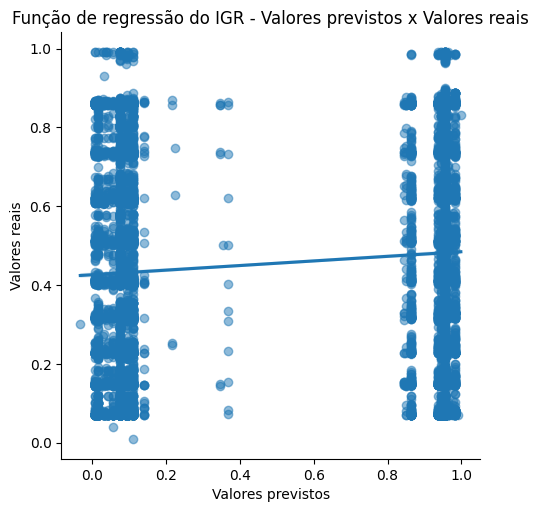

In [712]:
df_regressao = feature_store_credito_22.query("percentual_pago != 1").query("percentual_pago != 0")

sns.lmplot(x='y_predict' , y='percentual_pago', data=df_regressao, scatter_kws={'alpha': 0.5})

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")
plt.show()